Epoch 1/20


/home/arun/tf_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1165/1165 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7766 - loss: 0.5877 - val_accuracy: 0.8553 - val_loss: 0.3831
Epoch 2/20
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8331 - loss: 0.3998 - val_accuracy: 0.8525 - val_loss: 0.3470
Epoch 3/20
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8499 - loss: 0.3561 - val_accuracy: 0.8831 - val_loss: 0.3047
Epoch 4/20
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8716 - loss: 0.3265 - val_accuracy: 0.9023 - val_loss: 0.2828
Epoch 5/20
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8927 - loss: 0.3040 - val_accuracy: 0.9013 - val_loss: 0.2840
Epoch 6/20
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8955 - loss: 0.2958 - val_accuracy: 0.9010 - val_loss: 0.2615
Epoch 7/20
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9031 - loss: 0.2808 - val_accuracy: 0.9081 - val_loss: 0.2743
Epoch 8/20
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9058 - loss: 0.2750 - val

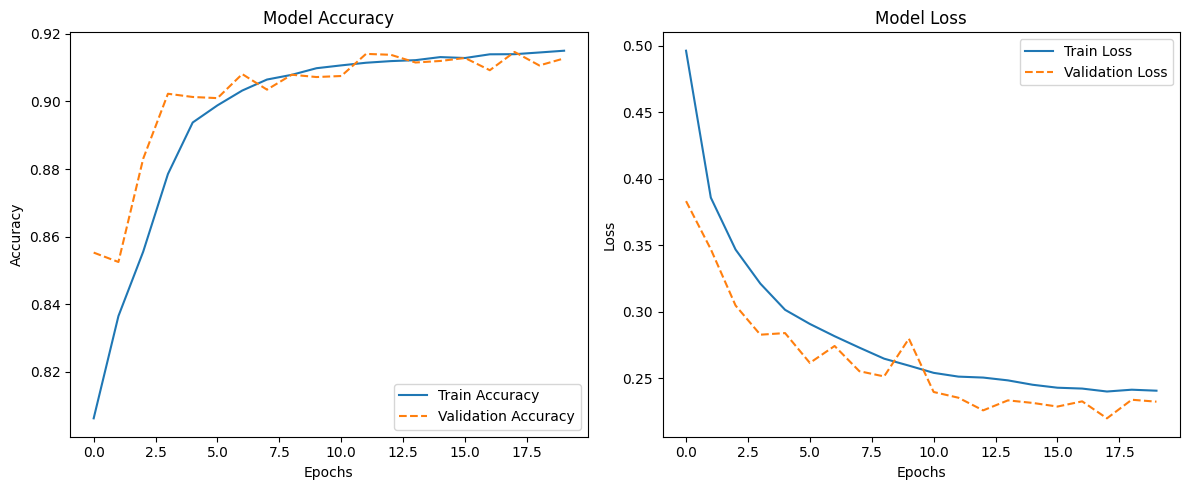

<Figure size 640x480 with 0 Axes>

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import pickle

# Load dataset
train_file = "./datasets/UNSW_NB15_training-set.csv"
test_file = "./datasets/UNSW_NB15_testing-set.csv"

data_train = pd.read_csv(train_file)
data_test = pd.read_csv(test_file)

# Drop unnecessary column
data_train.drop(columns=['id'], inplace=True)
data_test.drop(columns=['id'], inplace=True)

# Use only selected Zeek-compatible features
selected_features = [
        'proto', 'service', 'state',
    'dur', 'sbytes', 'dbytes',
    'spkts', 'dpkts',
    'label'
]

data_train = data_train[selected_features]
data_test = data_test[selected_features]

# Encode categorical fields
categorical_cols = ['proto', 'service', 'state']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data_train[col] = le.fit_transform(data_train[col])
    data_test[col] = data_test[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    label_encoders[col] = le

# Save label encoders for inference
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

# Convert to float32
data_train = data_train.astype(np.float32)
data_test = data_test.astype(np.float32)

# Separate features and labels
X_train = data_train.drop(columns=['label']).values
X_test = data_test.drop(columns=['label']).values
y_train = data_train['label'].values
y_test = data_test['label'].values

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, shuffle=True
)

# Reshape for CNN input
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Define CNN-GRU model
def build_binary_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.5),
        GRU(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        GRU(32, kernel_regularizer=l2(0.001)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Compute class weights to reduce false positives
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Build and train the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_binary_model(input_shape)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128,
    shuffle=True,
    class_weight=class_weights_dict,
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

# Predict and calculate false positives
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix:\n{cm}")
print(f"False Positives (Normal → Attack): {fp}")
print(f"False Negatives (Attack → Normal): {fn}")

# Save the model
model.save("cnn_gru_conn_dns_ssl_binary.keras")

# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig("training_plot_conn_dns_ssl_binary.png")
